In [1]:
from skimage import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
# from Models import U_net3D
import sklearn


c:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(500, 500, 100)


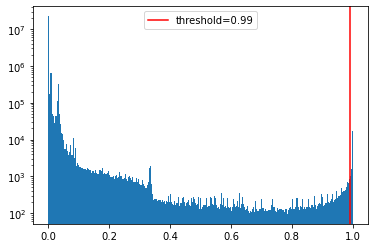

In [54]:
folder = '../5 Analysis, results/MBT_NET_1/commit 2 - 015c0a6e7a3d787129bede3d113a1f81c369b4d0'
fname = 'U_net_1_epoch_198-class_1.npy'
mask_macrophages = np.load(f'{folder}/{fname}')
print(mask_macrophages.shape)
threshold = 0.99

plt.hist(mask_macrophages.flatten(), bins=300);
plt.yscale('log')
plt.axvline(threshold, label=f'{threshold=}', c='r')
plt.legend()


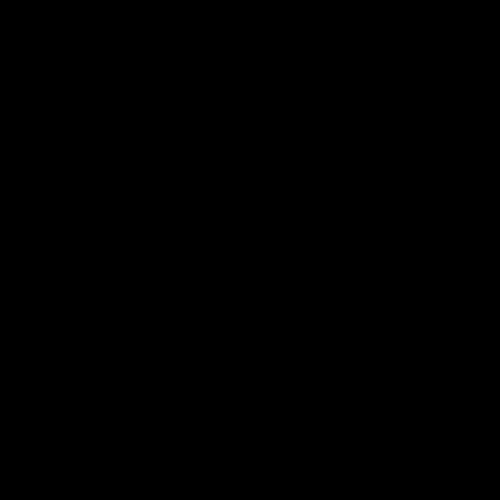
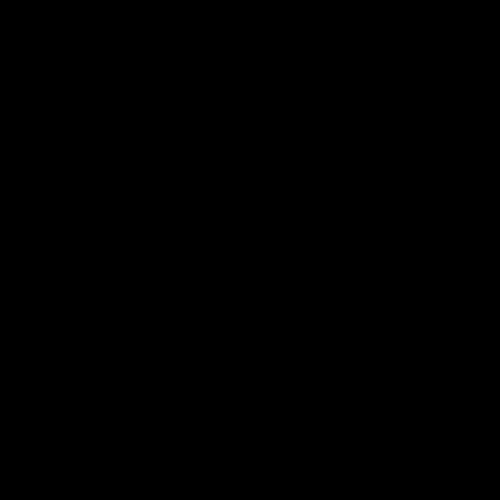
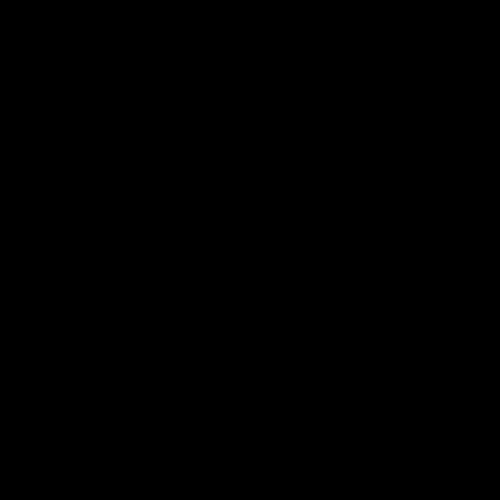
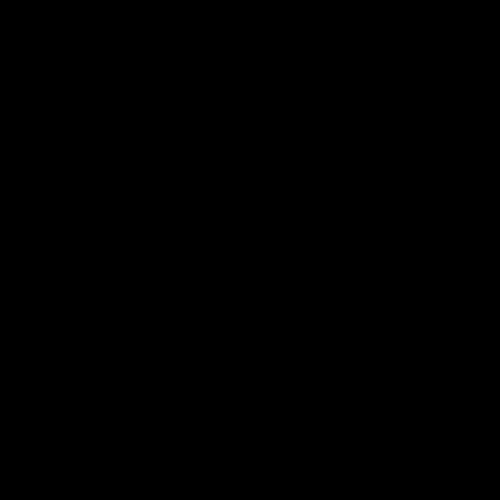
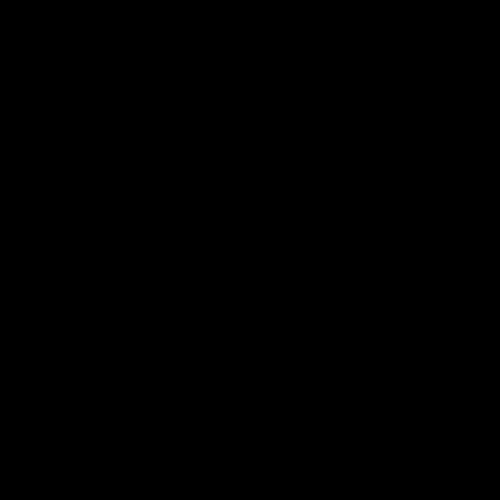
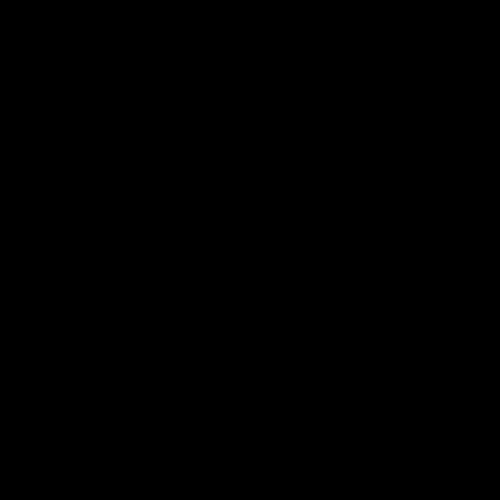
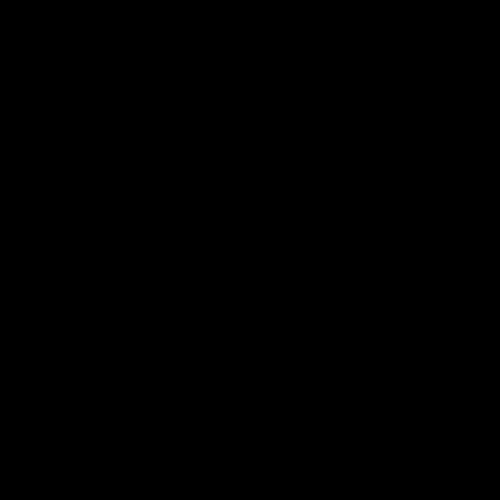
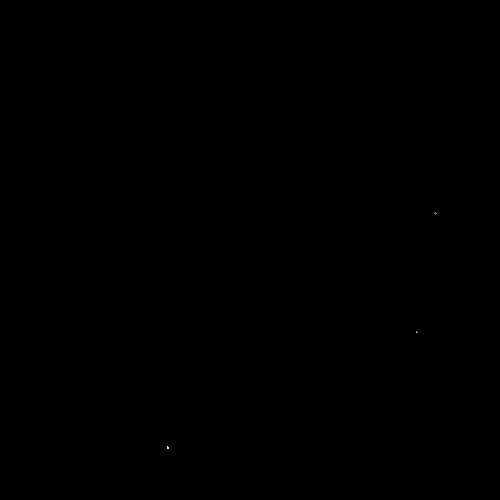
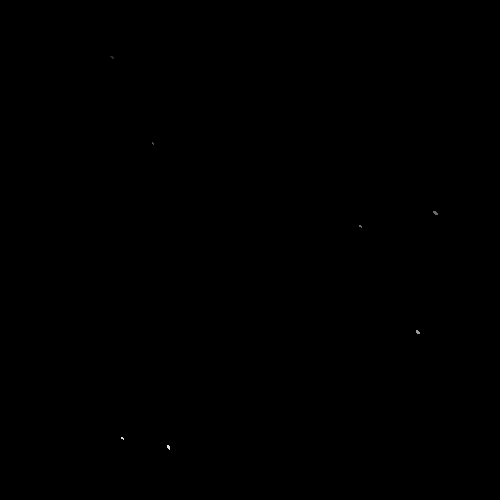
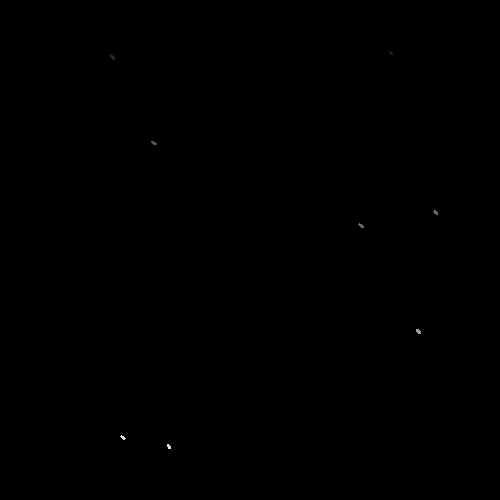
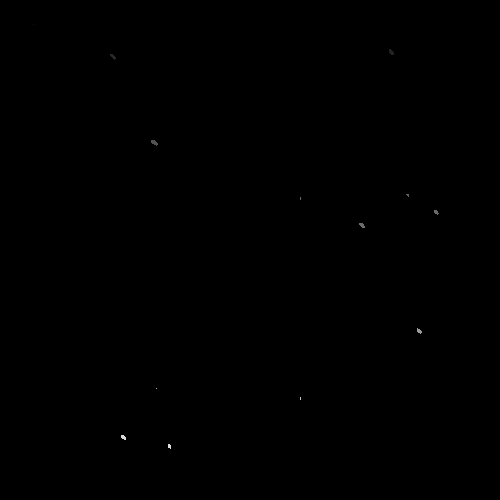
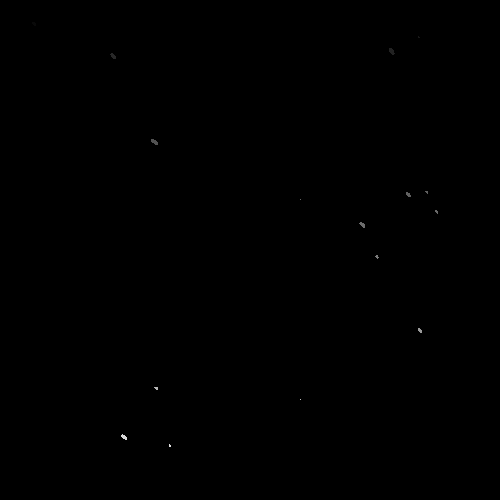
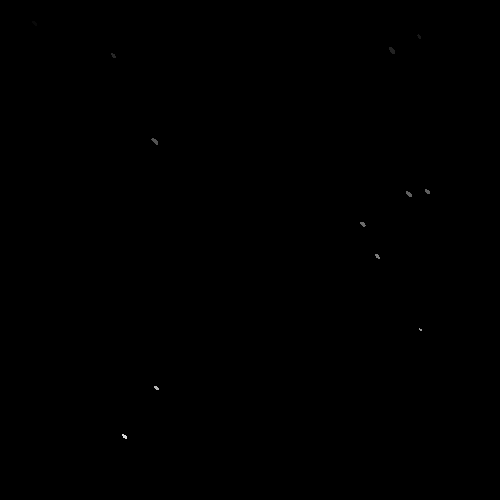
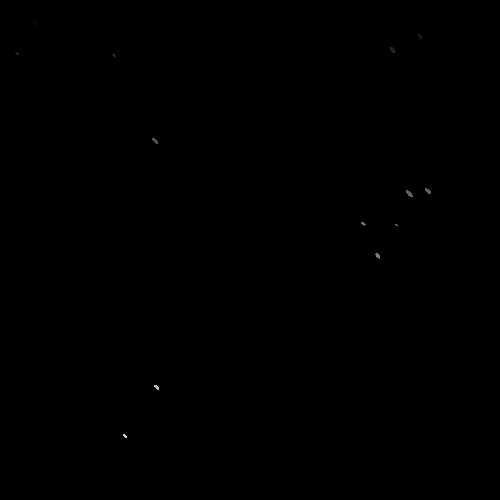
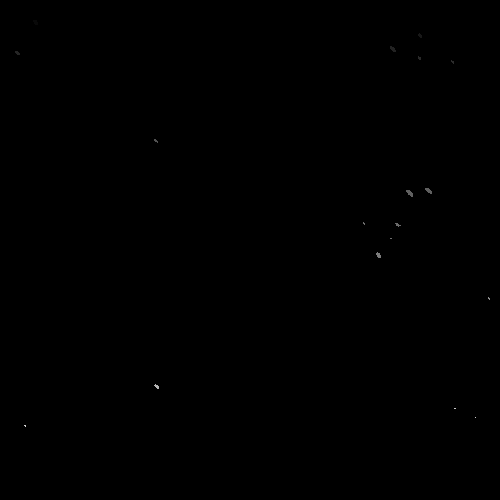
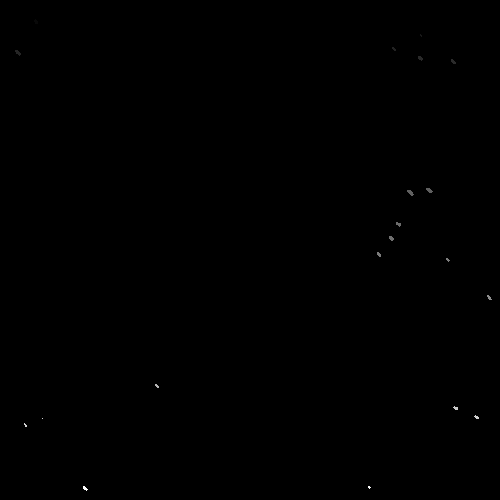
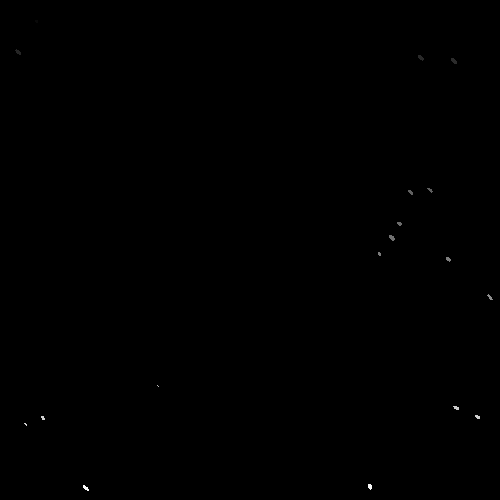
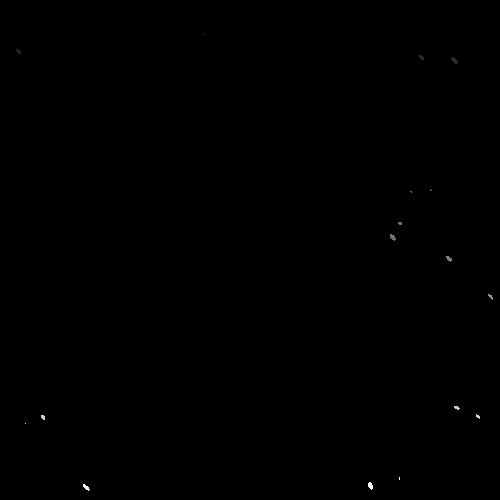
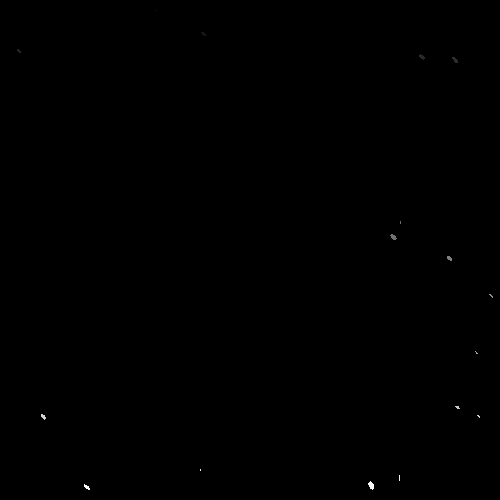
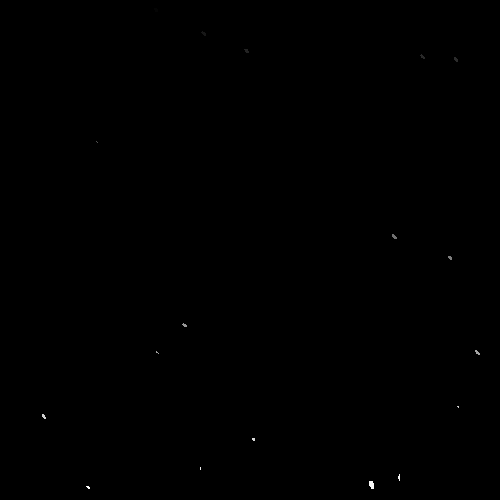
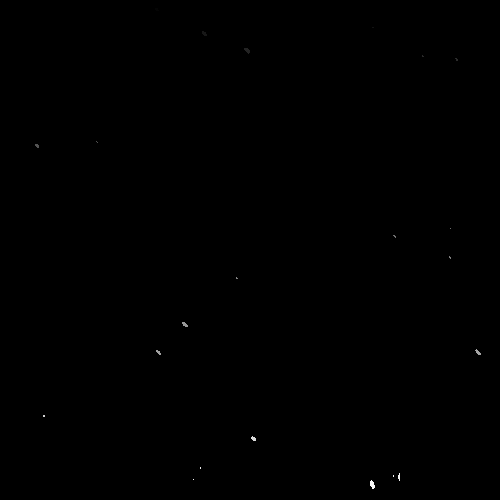
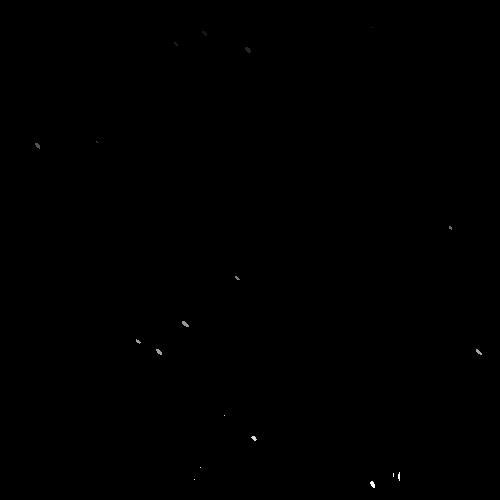
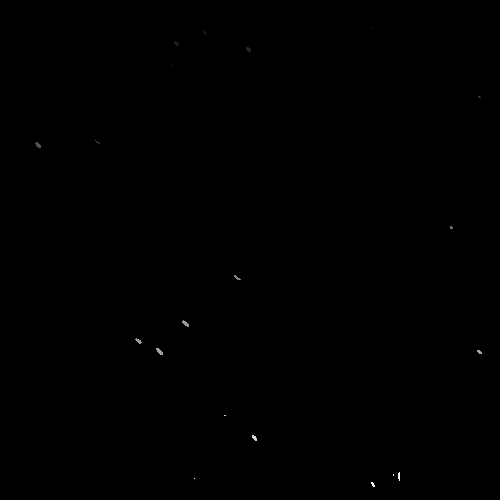
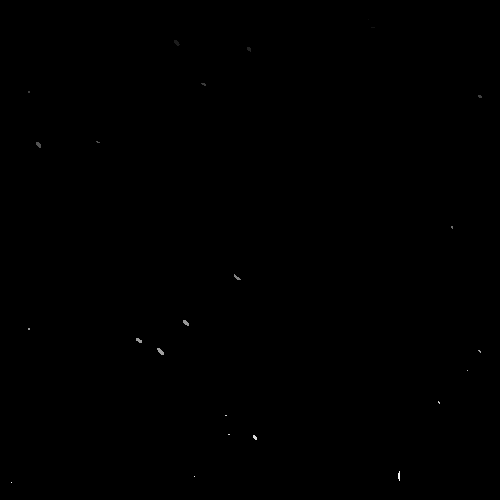
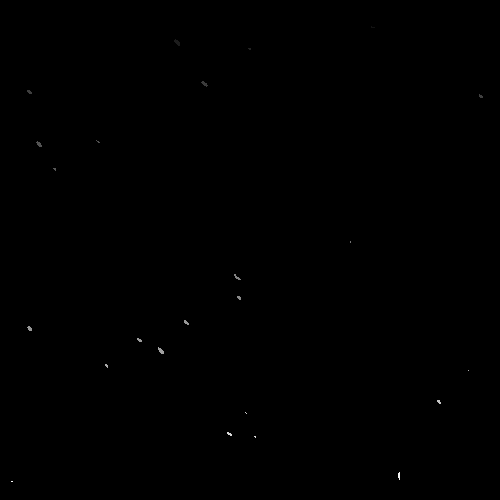
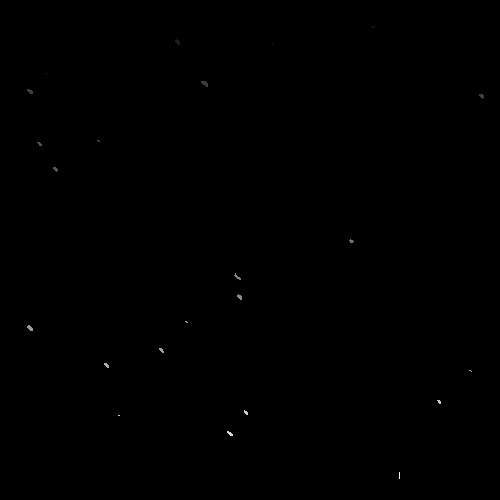
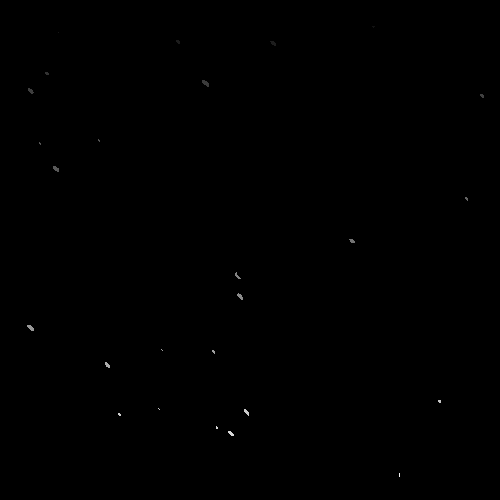
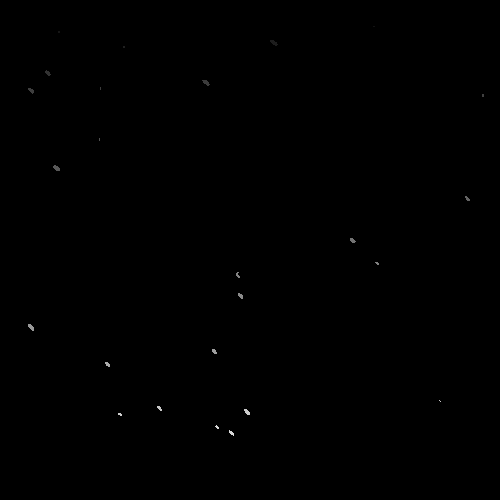
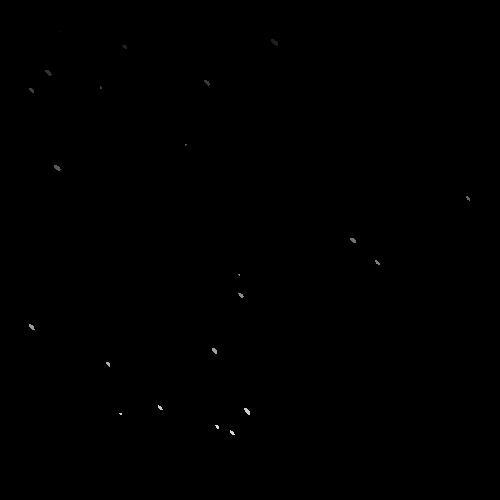
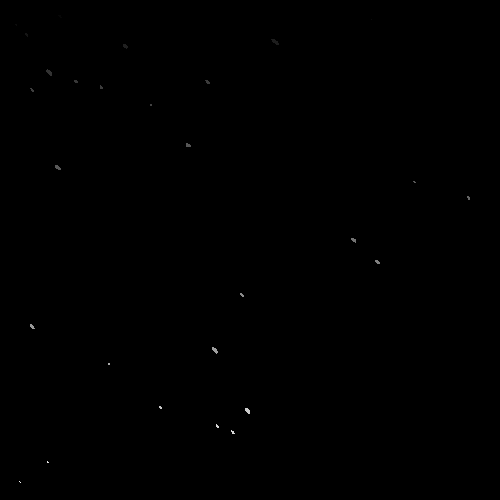
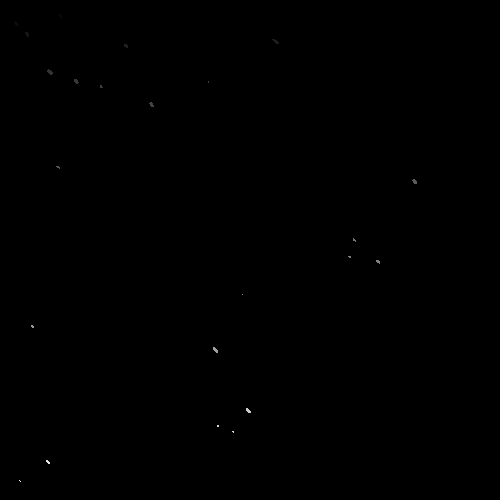
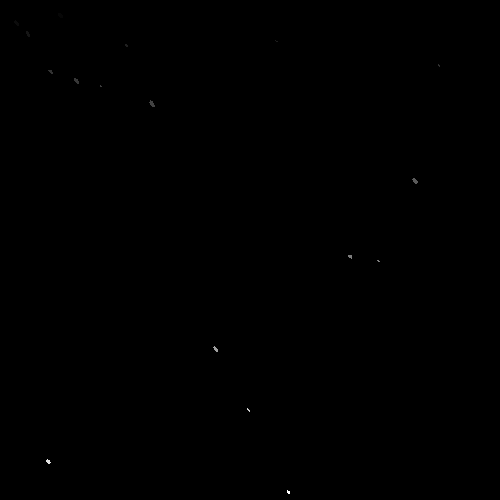
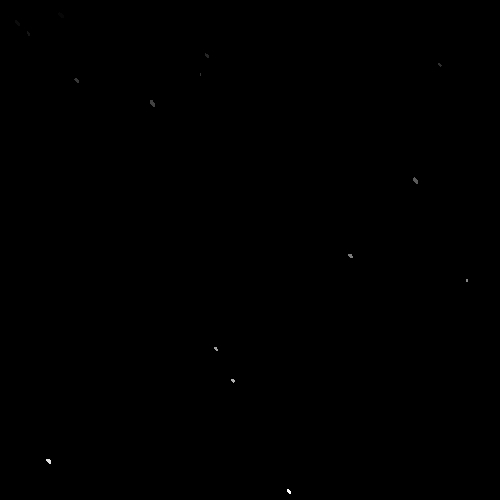
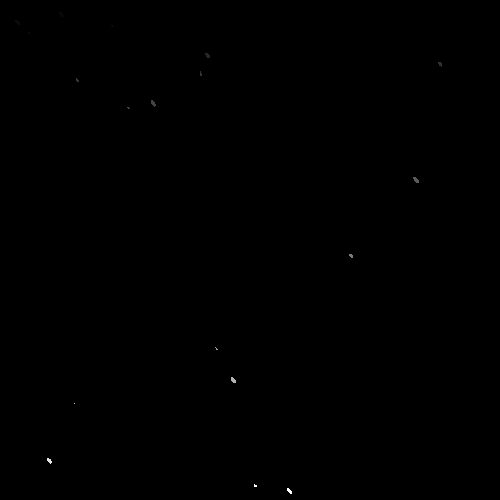
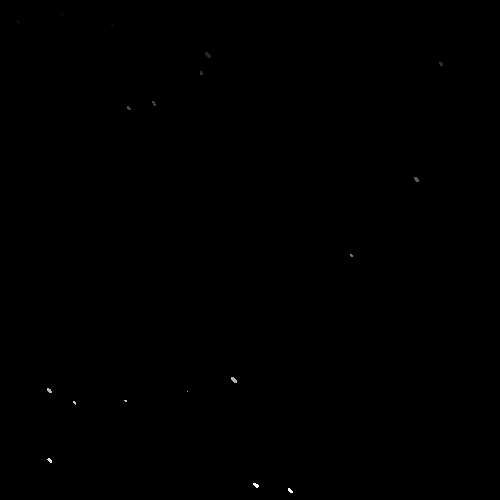
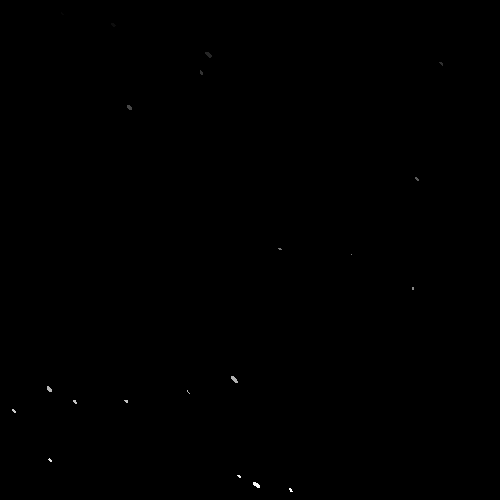
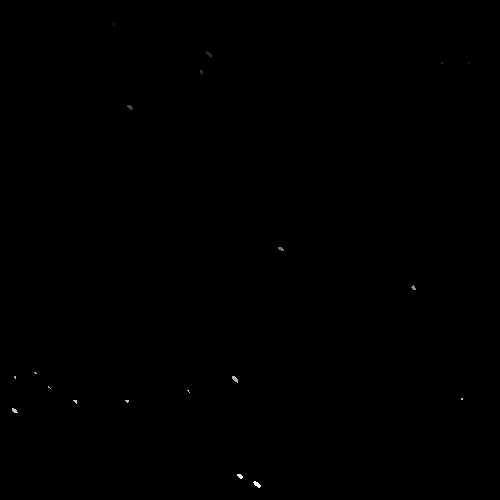
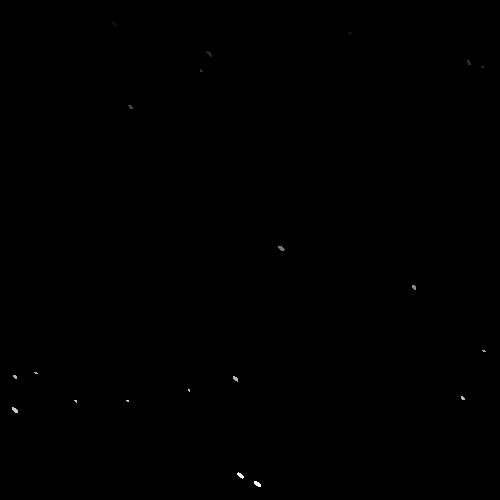
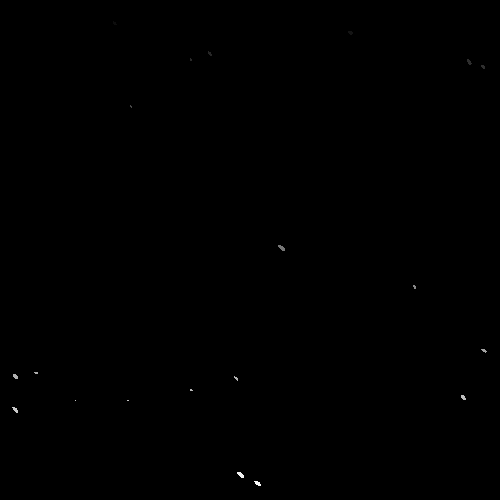
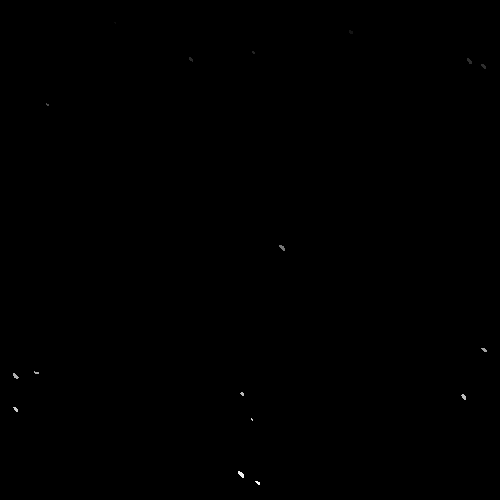
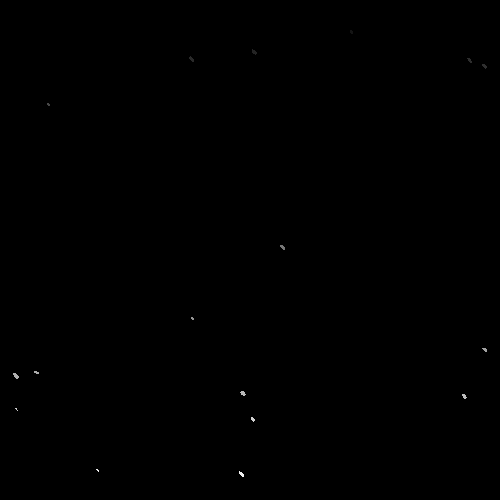
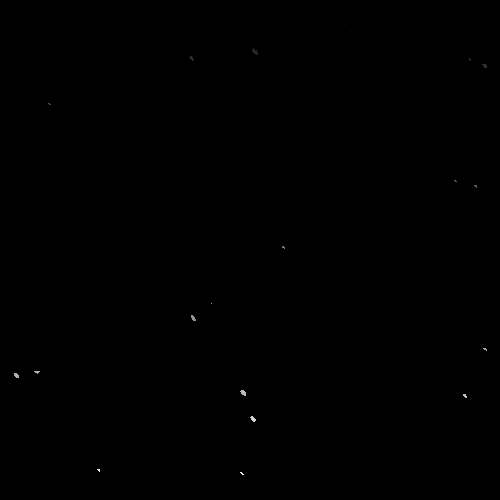
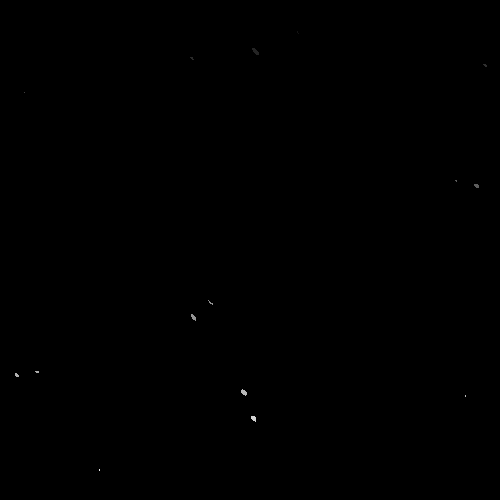
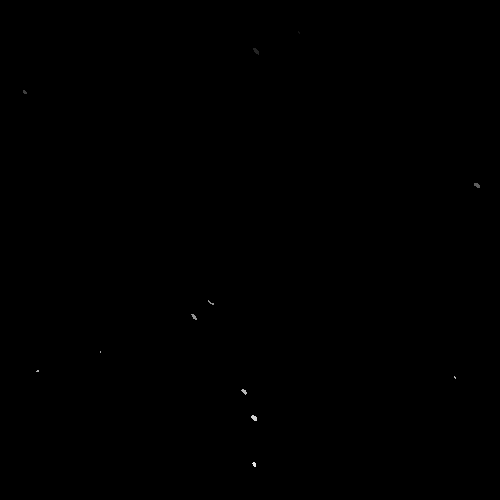
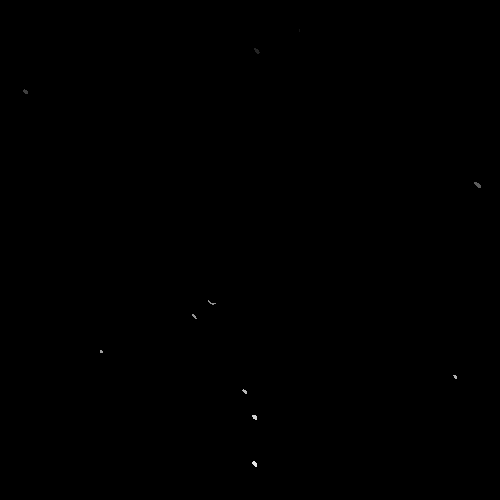
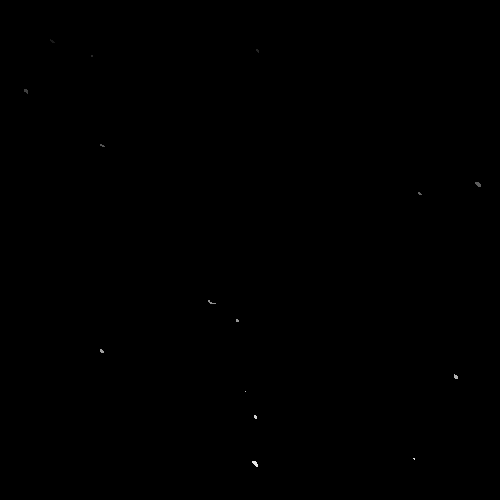
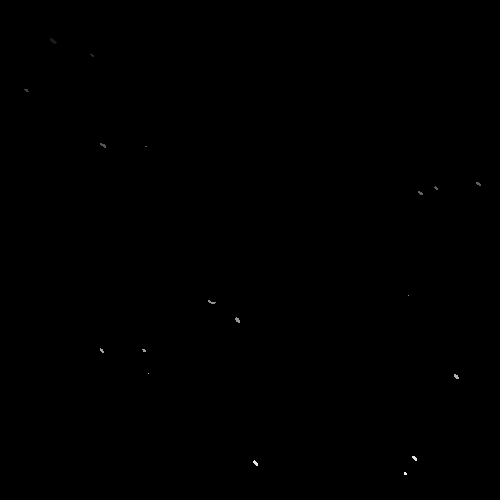
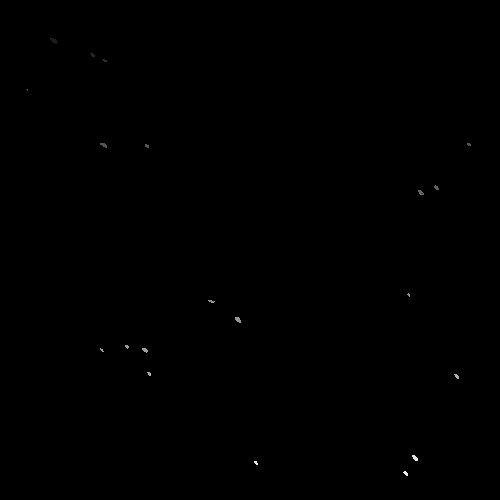
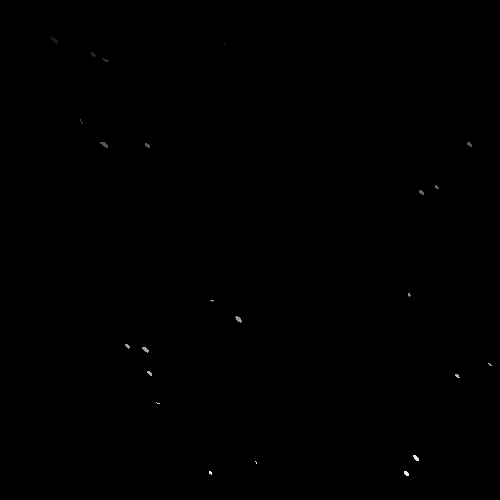
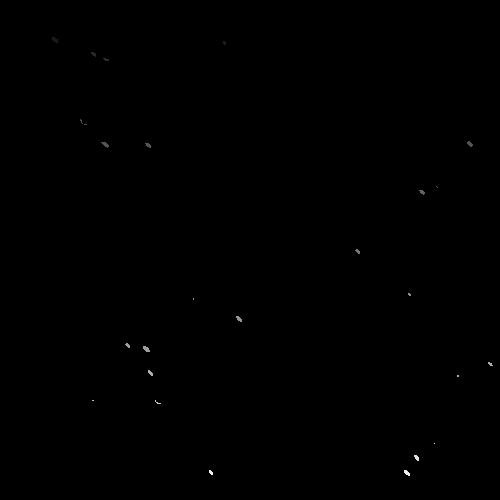
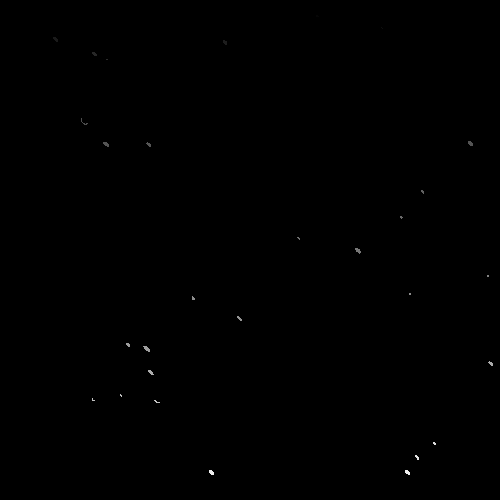
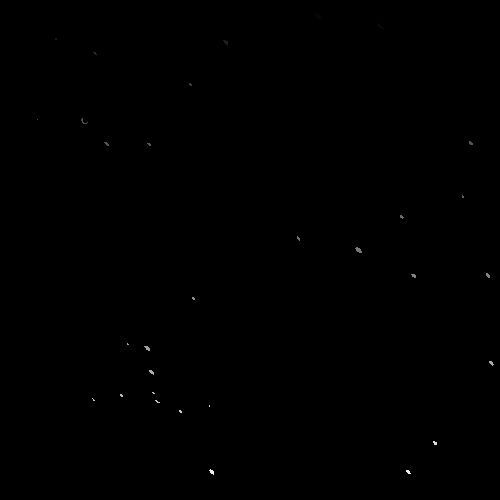
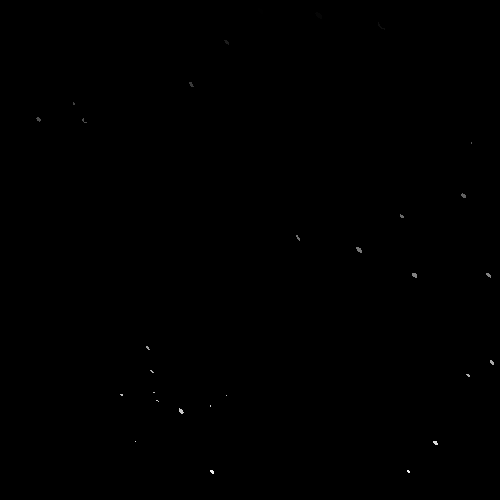
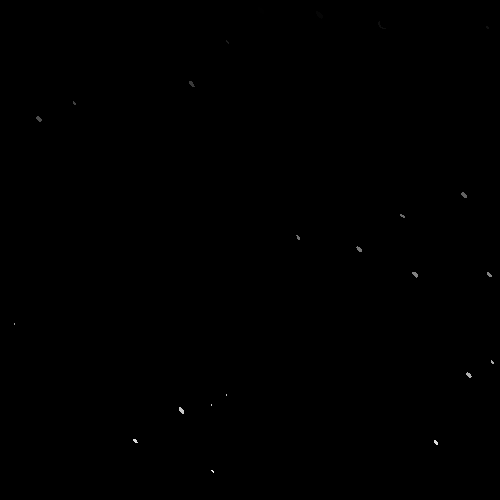
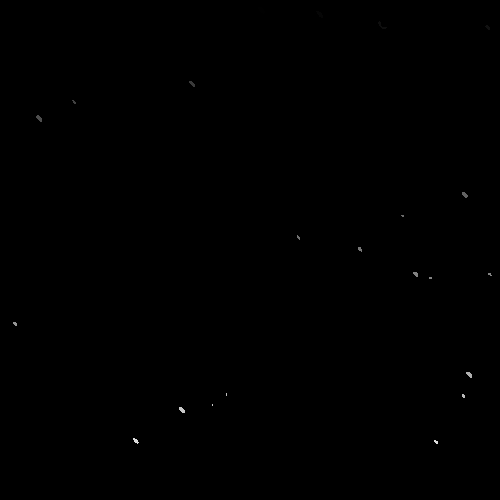
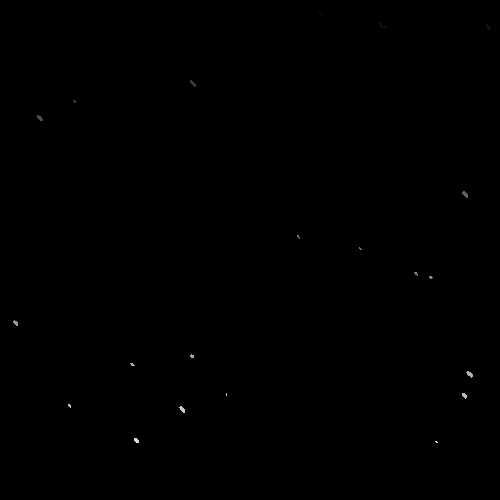
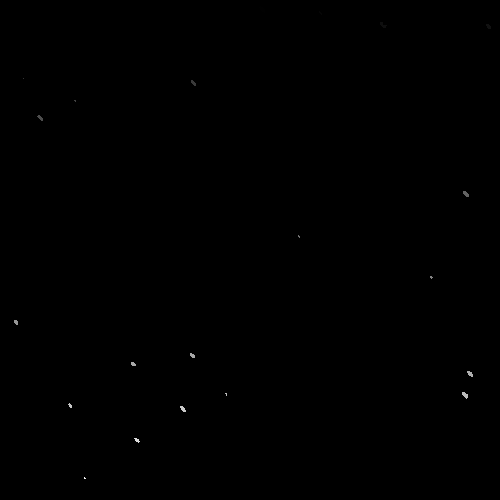
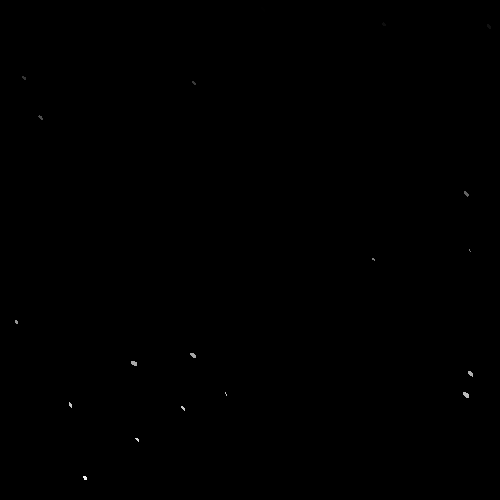
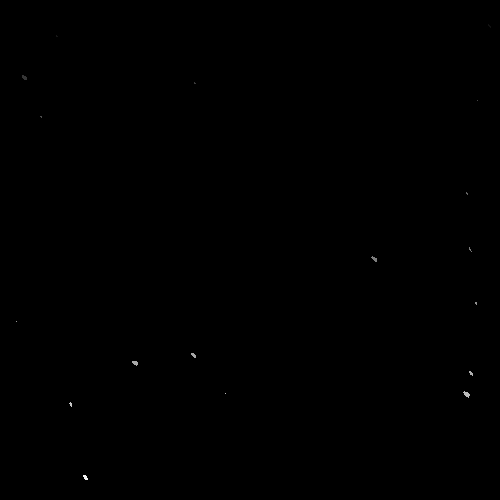
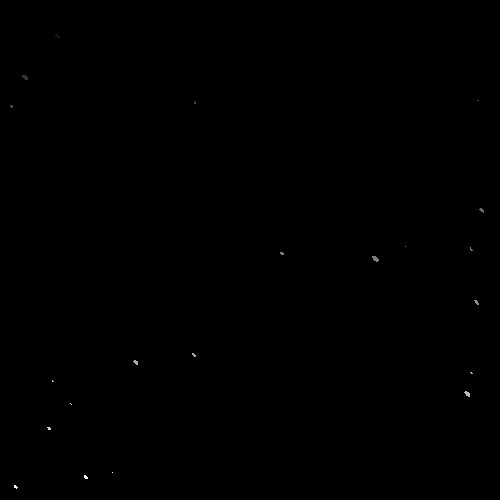
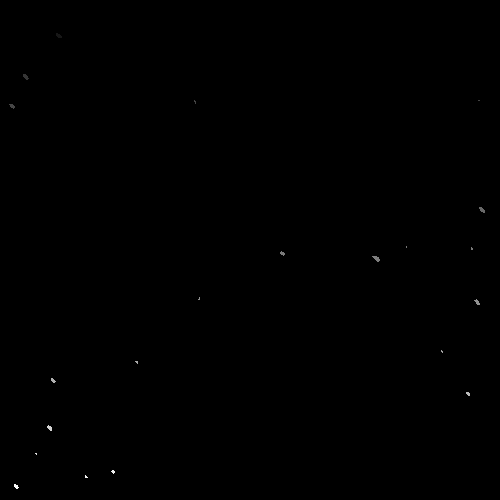
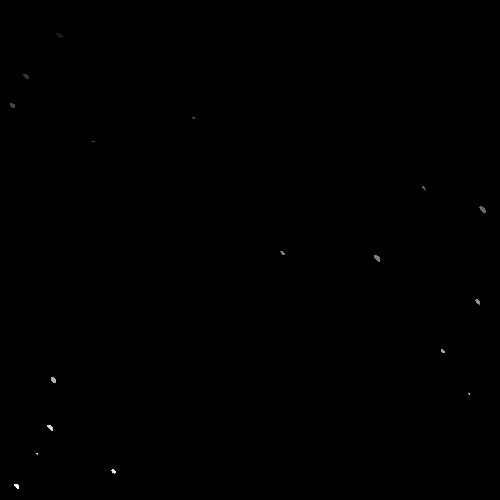
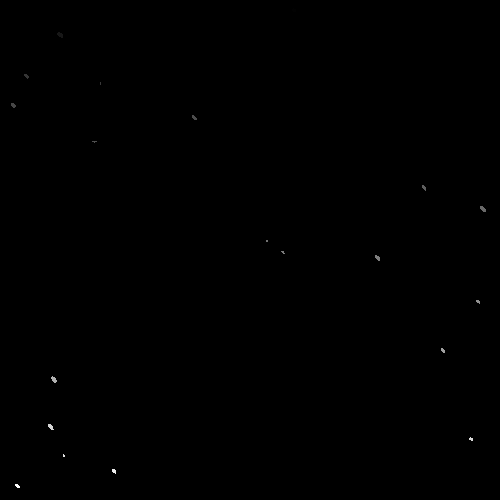
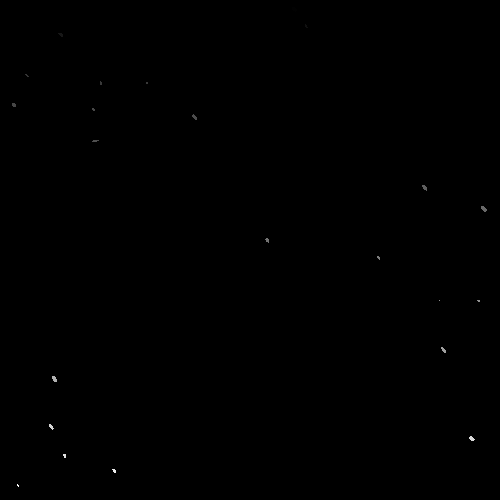
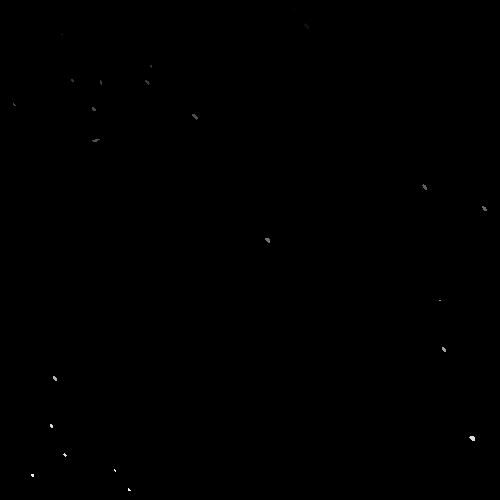
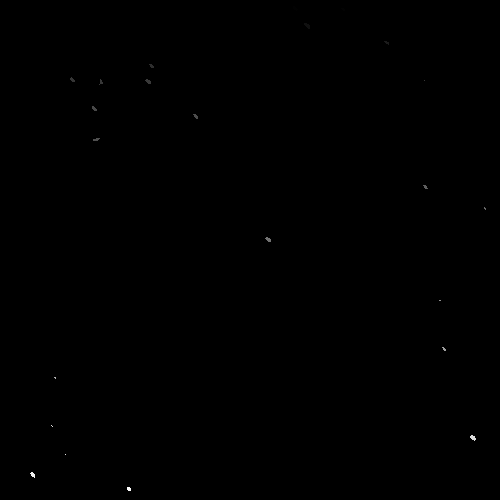
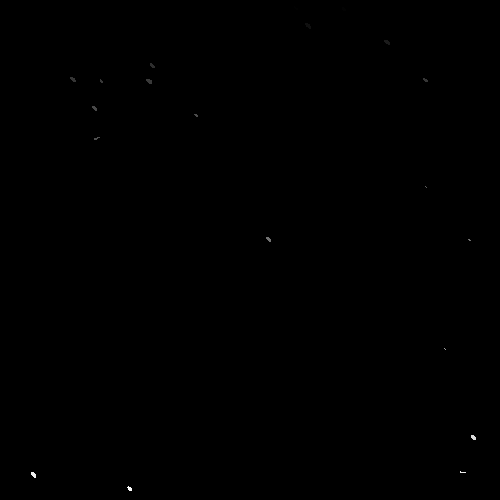
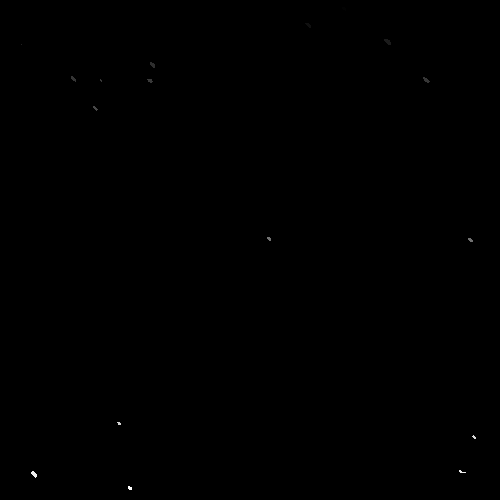
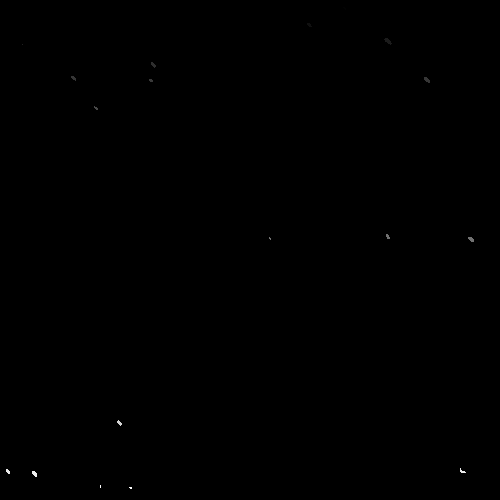
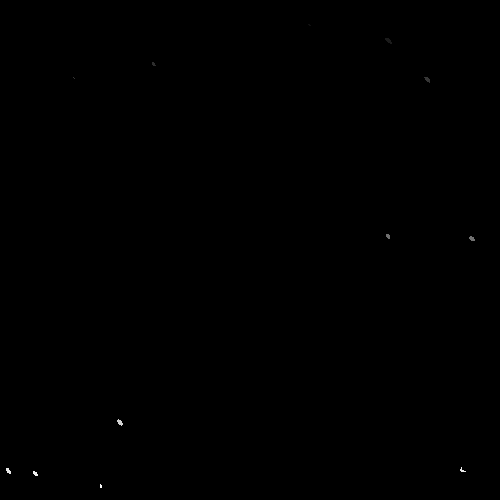
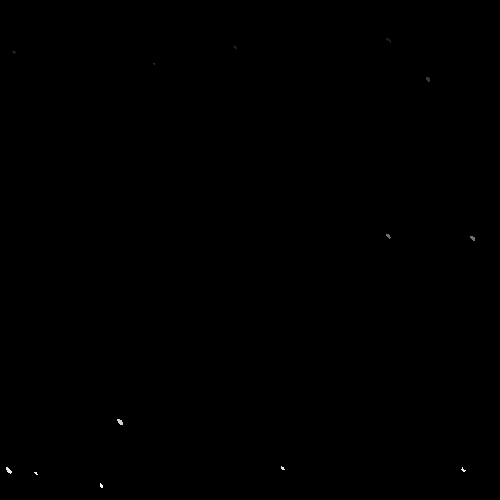
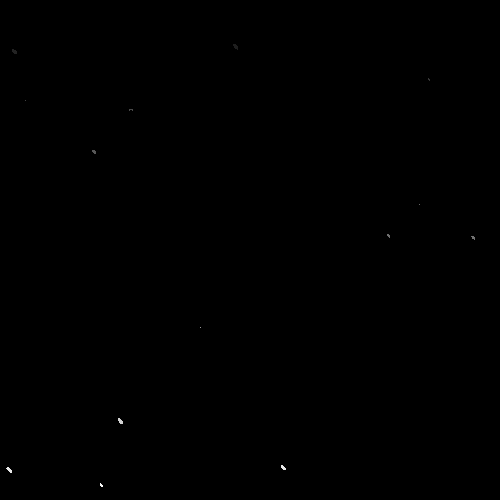
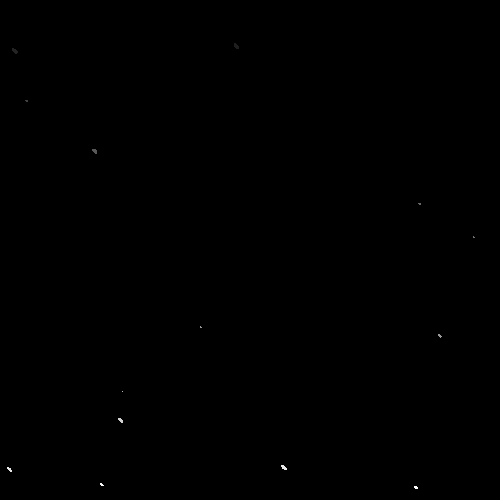
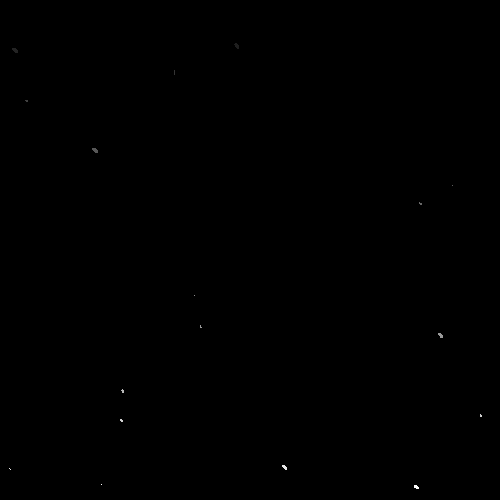
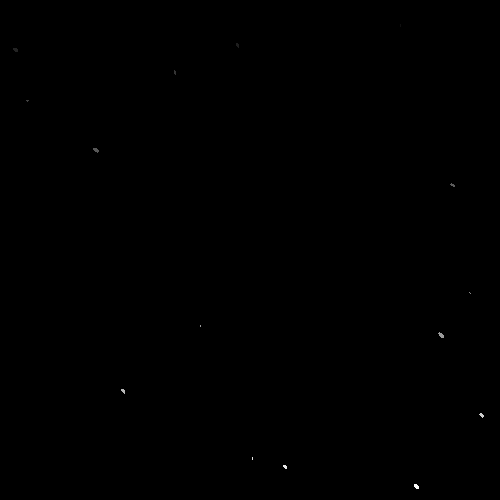
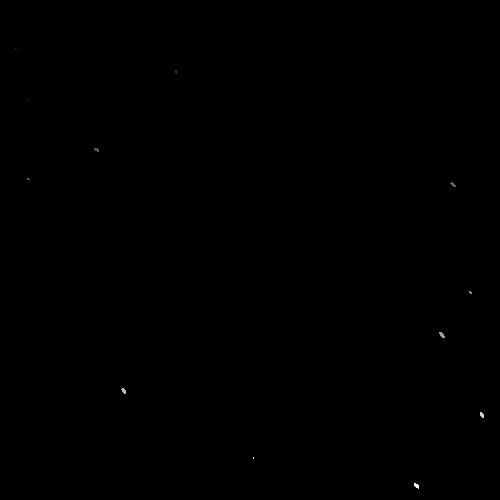
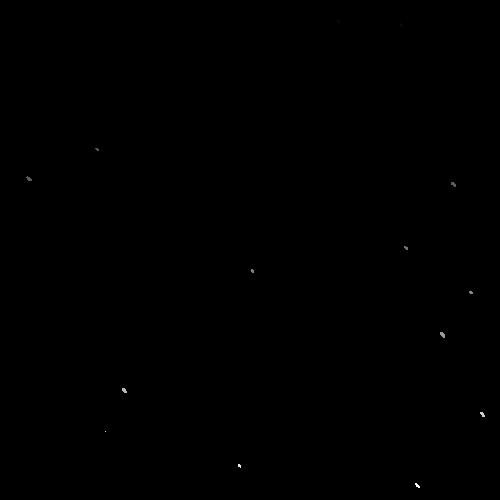
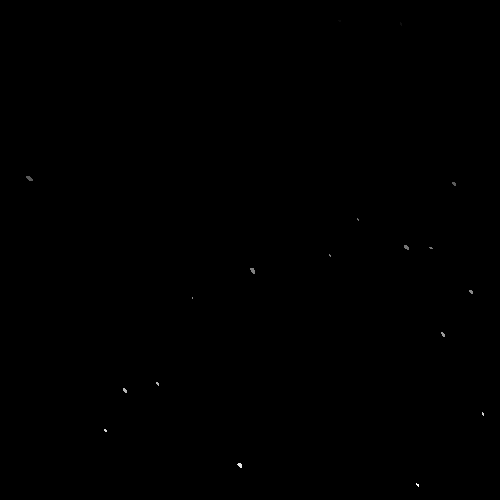
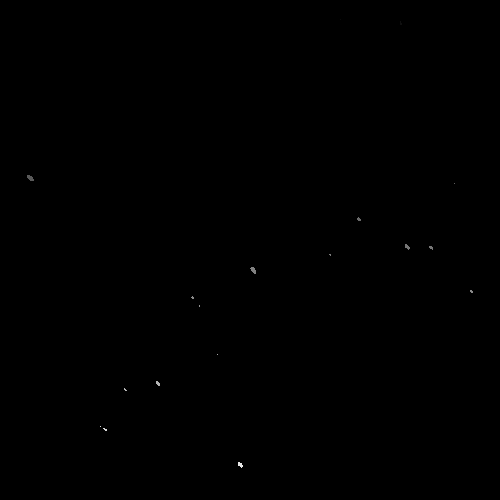
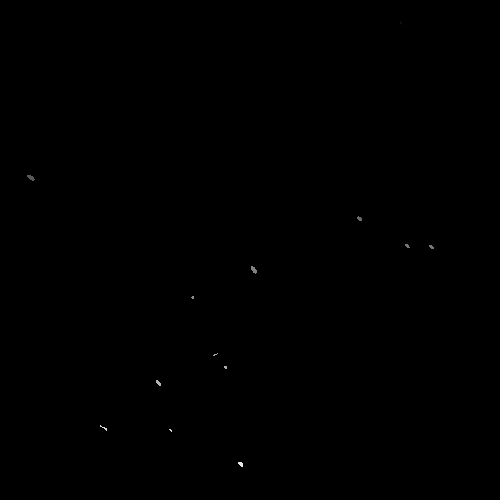
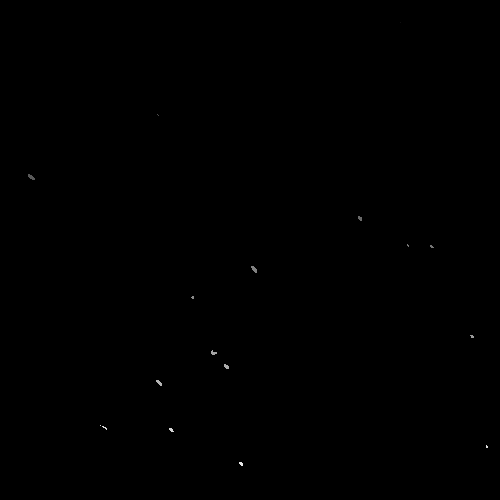
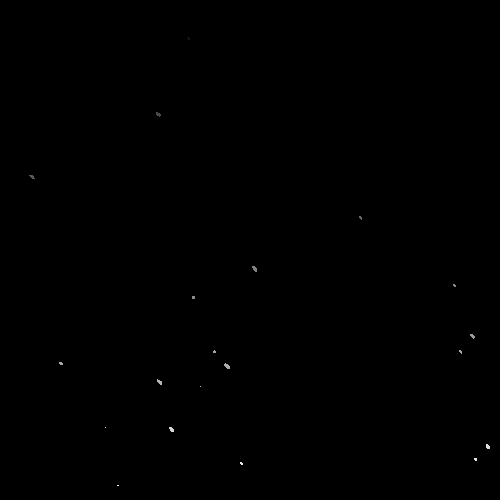
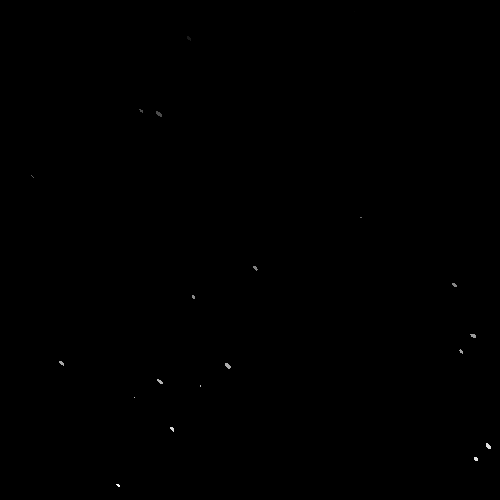
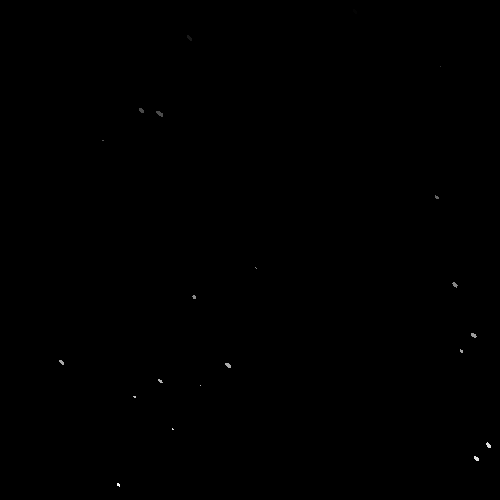
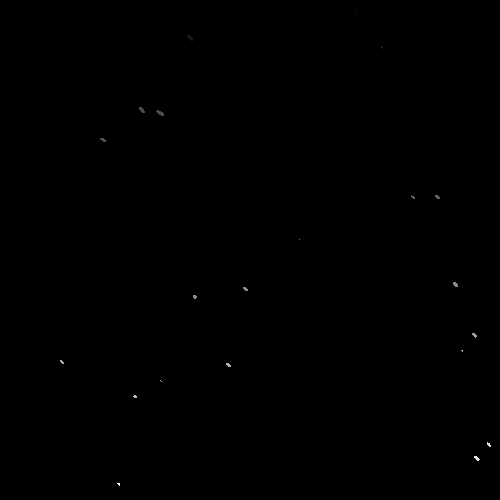
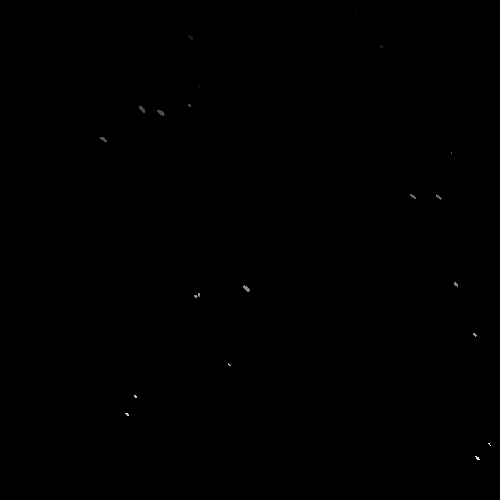
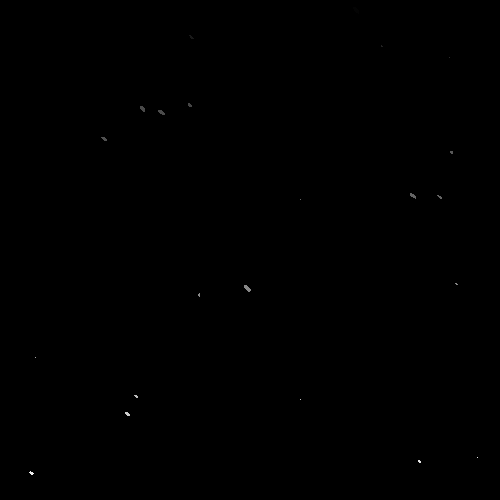
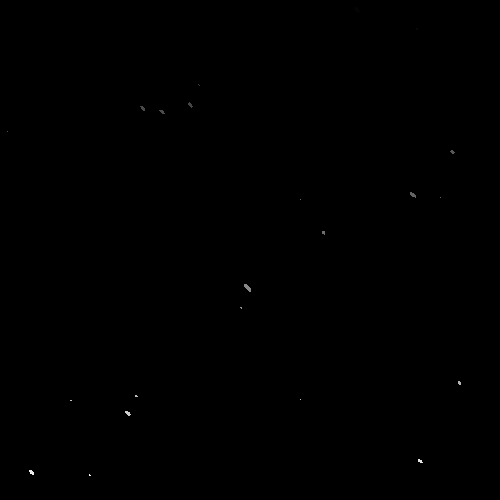
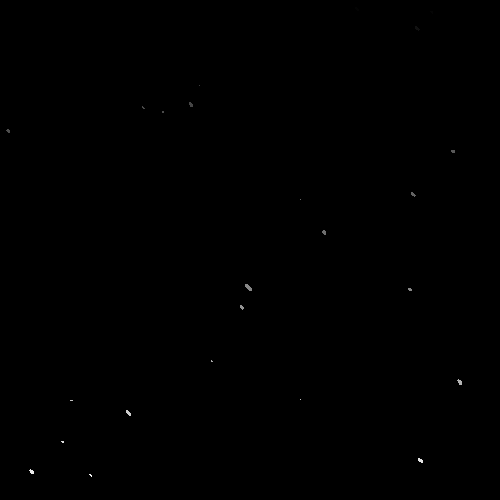
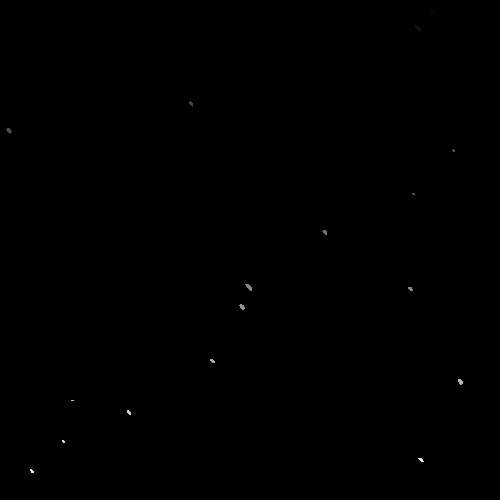
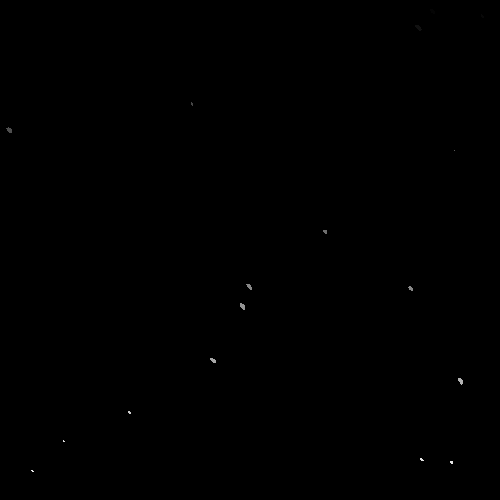
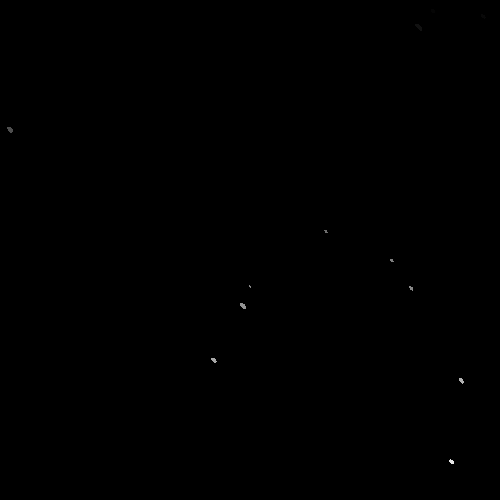
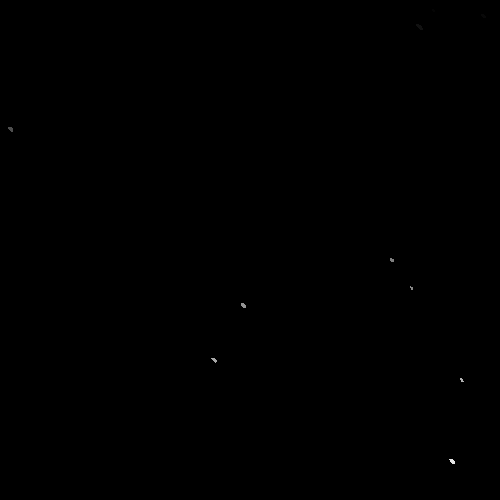
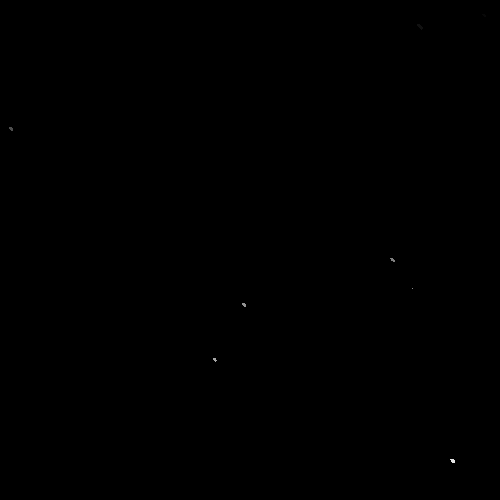
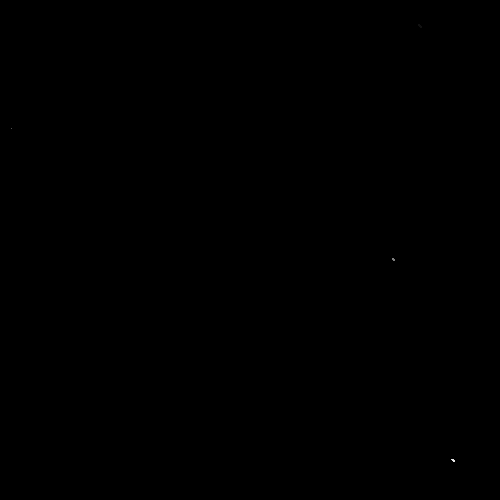
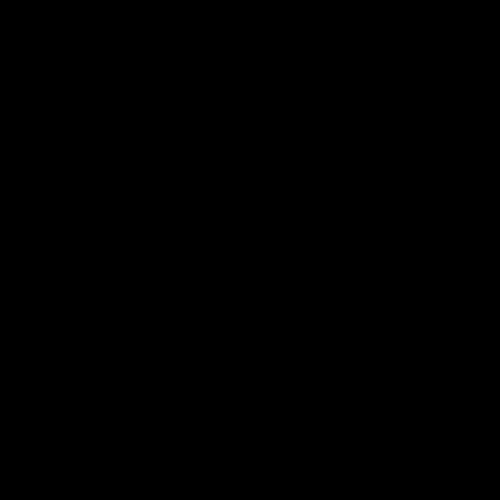
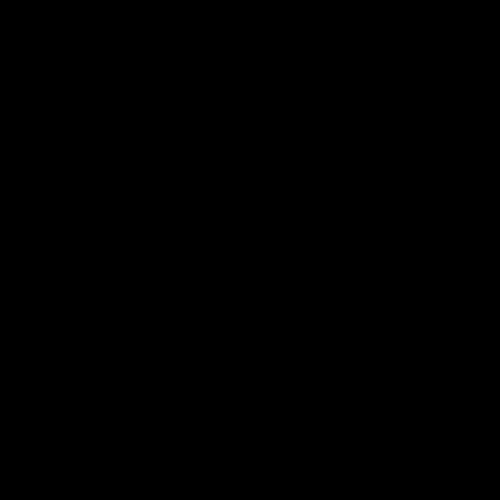
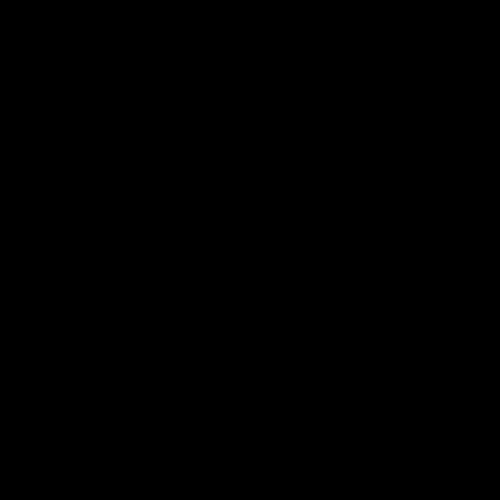
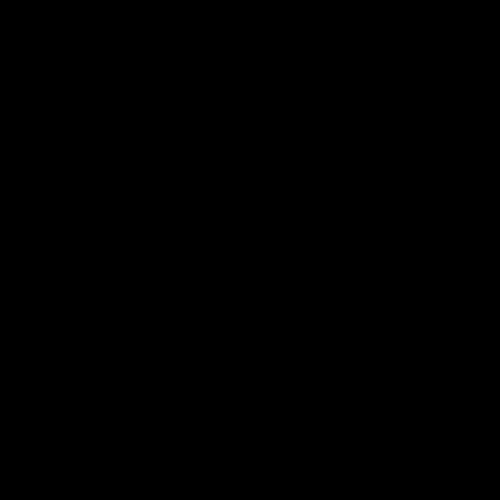
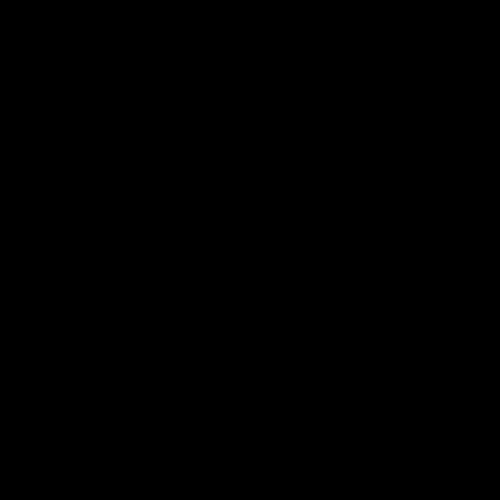
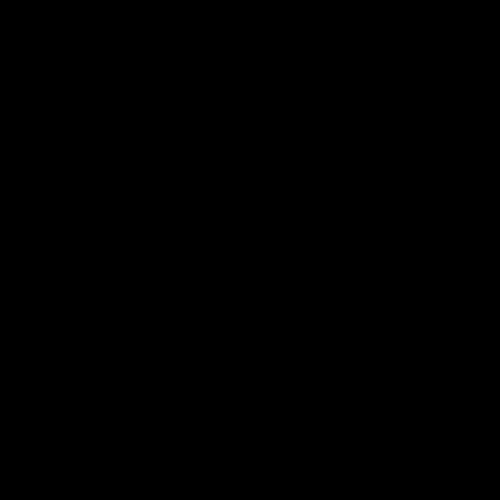

In [59]:


from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import plotly
import plotly.express as px



# apply threshold
mask = mask_macrophages > threshold
# remove artifacts connected to image border
cleared = clear_border(mask)

# label image regions
label_image = label(cleared)
# label_image = size_threshold(label_image, size_max=700)
label_image = np.expand_dims(label_image, axis=0)
label_image = np.transpose(label_image, [3,0,1,2])
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
# image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

# fig = px.imshow(label_image, facet_col=1, animation_frame=0,
#                 binary_string=True)
# plotly.io.show(fig)

In [18]:
label_image.max()


281

In [66]:
df = pd.read_csv('data/raw/stack_0.csv', index_col=0)
N = df['class'].value_counts()
N

Macrophage    264
T_Cell        236
Name: class, dtype: int64

In [67]:
def size_threshold(labeled_mask, size_max, size_min=0):
    mask = np.copy(labeled_mask)
    for i in range(mask.max()):
        V = np.sum(mask == i)
        if size_max > V and V > size_min:
            mask[mask==i] = 0

    mask[mask != 0] = 1
    mask = label(mask)
    return mask

In [70]:
def count_cells(mask, threshold):
    bmask = mask > threshold
    cleared = clear_border(bmask)

    label_image = label(cleared)
    # label_image = size_threshold(label_image, size_max=700)
    cell_N = label_image.max()
    return cell_N

folder = '../5 Analysis, results/MBT_NET_1/commit 2 - 015c0a6e7a3d787129bede3d113a1f81c369b4d0'
fname_macrophage = 'U_net_1_epoch_198-class_0.npy'
fname_tcell = 'U_net_1_epoch_198-class_1.npy'
mask_macrophages = np.load(f'{folder}/{fname_macrophage}')
mask_tcells = np.load(f'{folder}/{fname_tcell}')
threshold = 0.99
N_macro = count_cells(mask_macrophages, threshold)
N_tcell = count_cells(mask_tcells, threshold)

In [71]:
results = pd.DataFrame(
    {'class': ['Macrophage', 'T_Cell'],
    'real': [N['Macrophage'], N['T_Cell']],
    'predicted': [N_macro, N_tcell]
    }
)

results['misclassified %'] = np.abs((results['real'] - results['predicted']) / results['real'] * 100)
results

,class,real,predicted,misclassified %
0,Macrophage,264,281,6.439394
1,T_Cell,236,298,26.271186


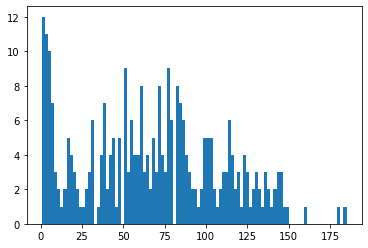

In [60]:
def size_hist(mask):
    distr = []
    for i in range(label_image.max()):
        V = np.sum(label_image == i)
        distr.append(V)

    distr = sorted(distr)[:-1]
    plt.hist(distr, bins=100);
    return distr

distr = size_hist(mask_macrophages);